In [6]:
import mrcnn
import mrcnn.config
import mrcnn.model
import mrcnn.visualize
import cv2
import os
import final
import tensorflow as tf

In [2]:
# load the class label names from disk, one label per line

CLASS_NAMES = ['BG', 'armchair', 'bed', 'door1', 'door2', 'sink1', 'sink2', 'sink3', 'sink4', 'sofa1', 'sofa2', 'table1', 'table2', 'table3', 'tub', 'window1', 'window2']

In [3]:
class SimpleConfig(final.CustomConfig):
    NAME = 'furnitures'  # Override in sub-classes

    GPU_COUNT = 1

    IMAGES_PER_GPU = 1

    NUM_CLASSES = 1 + 16 # Override in sub-classes

In [4]:
# Initialize the Mask R-CNN model for inference and then load the weights.
# This step builds the Keras model architecture.
model = mrcnn.model.MaskRCNN(mode="inference", 
                             config=SimpleConfig(),
                             model_dir=os.getcwd())

Instructions for updating:
Use fn_output_signature instead


2023-07-05 10:48:42.187944: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-05 10:48:42.225067: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-05 10:48:42.228097: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [8]:
# Load the weights into the model.
# Download the mask_rcnn_coco.h5 file from this link: https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
model.load_weights(filepath="../model_saves/iter2run4.h5", by_name=True)

In [9]:
# load the input image, convert it from BGR to RGB channel
image = cv2.imread("../dataset2/test/floor_image_22.tiff")
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Perform a forward pass of the network to obtain the results
r = model.detect([image], verbose=0)

# Get the results for the first image.
r = r[0]

print(image.shape, r['masks'].shape, r['class_ids'].shape, r['rois'].shape)

2023-07-05 10:49:06.791045: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8700


(2858, 6775, 3) (2858, 6775, 33) (33,) (33, 4)


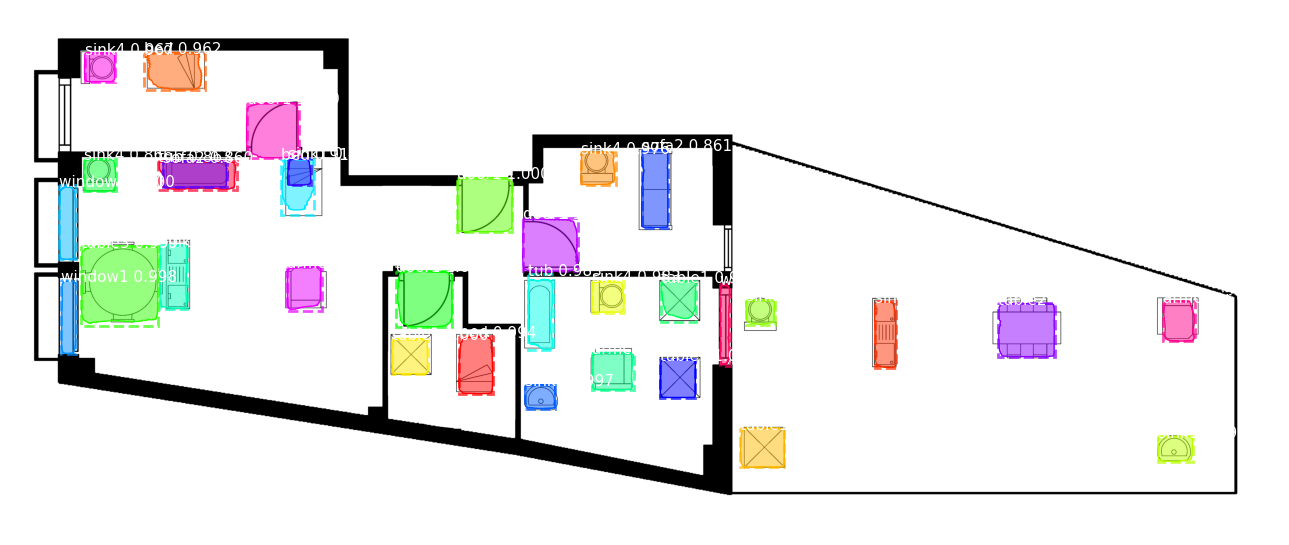

In [10]:
# Visualize the detected objects.
mrcnn.visualize.display_instances(image=image, 
                                  boxes=r['rois'], 
                                  masks=r['masks'], 
                                  class_ids=r['class_ids'], 
                                  class_names=CLASS_NAMES, 
                                  scores=r['scores'])